In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft, fftfreq

In [161]:
case_study = 'santamargherita'; title_str = 'Santa Margherita'
case_study = 'sarzana'; title_str = 'Sarzana'
case_study = 'vareseligure'; title_str = 'Varese Ligure'
case_study = 'calice'; title_str = 'Calice al Cornoviglio'
#case_study = 'lafoce'; title_str = 'La Foce'

In [162]:
filename = case_study + '.txt'
df = pd.read_csv(filename,delimiter='\t')
df

,year,month,rainfall
0,1932,Jan,103.0
1,1932,Feb,20.0
2,1932,Mar,258.0
3,1932,Apr,97.0
4,1932,May,262.0
...,...,...,...
943,2010,Aug,140.2
944,2010,Sep,368.4
945,2010,Oct,165.8
946,2010,Nov,743.8


<ipython-input-163-71b40b59fbaa>:29: RuntimeWarning: divide by zero encountered in true_divide
  rainfall_nan = 1/rainfall_nan


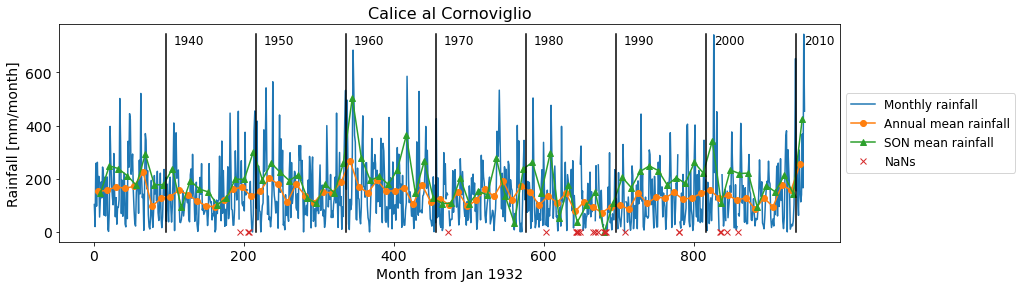

In [163]:
month_from_beg = np.arange(1,len(df.rainfall)+1) # count the number of months from the beginning.
rainfall_with_nan = df.rainfall
rainfall = np.nan_to_num(df.rainfall,nan=0)

plt.figure(figsize=(14,4))
plt.plot(month_from_beg, rainfall_with_nan)
plt.ylabel('Rainfall [mm/month]',fontsize=14)
plt.xlabel('Month from ' + str(df.month[0]) +' '+ str(df.year[0]),fontsize=14)
plt.title(title_str,fontsize=16)

year_from_beg = np.arange(1,round(len(rainfall_with_nan)/12)+1)
scale = 1 + 12*(year_from_beg-1)
#plt.plot(scale,np.zeros(len(scale)),'.') # Every Jan has a small dot on the time axis.

# Plot the annual rainfall and the SON rainfall.
annual_rainfall = np.zeros(len(year_from_beg))
son_rainfall = np.zeros(len(year_from_beg))

for k in range(len(year_from_beg)):
    annual_rainfall[k] = np.nansum(rainfall_with_nan[12*k:12*(k+1)])
    son_rainfall[k] = np.nansum(rainfall_with_nan[8+k*12:11+k*12])
    
plt.plot(scale+5,annual_rainfall/12,'o-') # Plot the mean annual rainfall
plt.plot(scale+8,son_rainfall/3,'^-') # Plot the mean annual rainfall
    
# Check if there are NaNs and replace them with 0.
rainfall_nan = np.zeros(len(df.rainfall))
rainfall_nan[np.isnan(df.rainfall)] = 1
rainfall_nan = 1/rainfall_nan
plt.plot(month_from_beg,rainfall_nan,'x')

plt.tick_params(axis='both', labelsize=14)

plt.legend(['Monthly rainfall', 'Annual mean rainfall', 'SON mean rainfall', 'NaNs'], fontsize=12,
          loc='center left', bbox_to_anchor=(1, 0.5))

# Plot some vertical lines with the decades.
extreme = np.max(rainfall)
y0 = df.year[0] # First year of the record.
if (case_study=='calice') or (case_study=='lafoce'):
    last_decade = 2020
else:
    last_decade = 2030
for yy in np.arange(1940,last_decade,10):
    offset = yy-y0
    plt.plot((scale[offset],scale[offset]),(0, extreme),'k')
    plt.text(scale[offset]+10, 0.95*extreme, str(yy), fontsize=12)
#    print(scale[offset])

plt.savefig(case_study + '_monthly_timeseries.png',bbox_inches = 'tight')

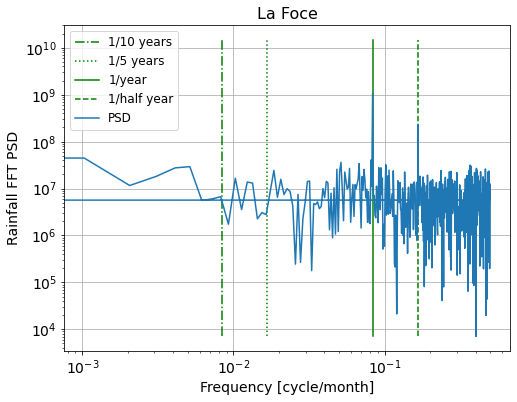

In [154]:
# Look at the FFT of the monthly data.
hat = fft(np.array(rainfall))
freq = fftfreq(len(rainfall)) # Cycles/month

plt.figure(figsize=(8,6))
psd = np.abs(hat)**2
a = np.min(psd)
b = np.max(psd)

plt.plot(1/120*np.array([1,1]),np.array([a,b]),'g-.')
plt.plot(1/60*np.array([1,1]),np.array([a,b]),'g:')
plt.plot(1/12*np.array([1,1]),np.array([a,b]),'g')
plt.plot(1/6*np.array([1,1]),np.array([a,b]),'g--')

plt.plot(freq, psd)

plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.ylabel('Rainfall FFT PSD',fontsize=14)
plt.xlabel('Frequency [cycle/month]',fontsize=14)
plt.legend(['1/10 years','1/5 years','1/year','1/half year','PSD'],fontsize=12)
plt.title(title_str,fontsize=16)
plt.tick_params(axis='both', labelsize=14)

plt.savefig(case_study + '_monthly_psd.png',bbox_inches = 'tight')

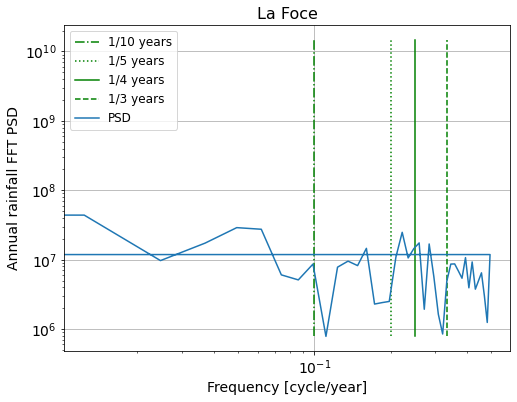

In [155]:
# Look at the FFT of the annual data.
hat = fft(np.array(annual_rainfall))
freq = fftfreq(len(annual_rainfall)) # Cycles/year

plt.figure(figsize=(8,6))
psd = np.abs(hat)**2
a = np.min(psd)
b = np.max(psd)

plt.plot(1/10*np.array([1,1]),np.array([a,b]),'g-.')
plt.plot(1/5*np.array([1,1]),np.array([a,b]),'g:')
plt.plot(1/4*np.array([1,1]),np.array([a,b]),'g')
plt.plot(1/3*np.array([1,1]),np.array([a,b]),'g--')

plt.plot(freq, psd)

plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.ylabel('Annual rainfall FFT PSD',fontsize=14)
plt.xlabel('Frequency [cycle/year]',fontsize=14)
plt.legend(['1/10 years','1/5 years','1/4 years','1/3 years','PSD'],fontsize=12)
plt.title(title_str,fontsize=16)
plt.tick_params(axis='both', labelsize=14)

plt.savefig(case_study + '_annual_psd.png',bbox_inches = 'tight')

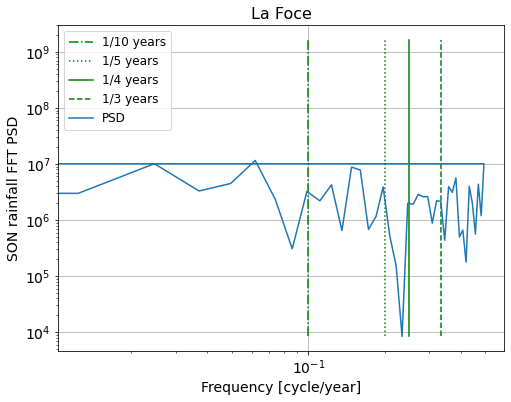

In [156]:
# Look at the FFT of the SON rainfall with annual step.
hat = fft(np.array(son_rainfall))
freq = fftfreq(len(son_rainfall)) # Cycles/year

plt.figure(figsize=(8,6))
psd = np.abs(hat)**2
a = np.min(psd)
b = np.max(psd)

plt.plot(1/10*np.array([1,1]),np.array([a,b]),'g-.')
plt.plot(1/5*np.array([1,1]),np.array([a,b]),'g:')
plt.plot(1/4*np.array([1,1]),np.array([a,b]),'g')
plt.plot(1/3*np.array([1,1]),np.array([a,b]),'g--')

plt.plot(freq, psd)

plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.ylabel('SON rainfall FFT PSD',fontsize=14)
plt.xlabel('Frequency [cycle/year]',fontsize=14)
plt.legend(['1/10 years','1/5 years','1/4 years','1/3 years','PSD'],fontsize=12)
plt.title(title_str,fontsize=16)
plt.tick_params(axis='both', labelsize=14)

plt.savefig(case_study + '_son_psd.png',bbox_inches = 'tight')

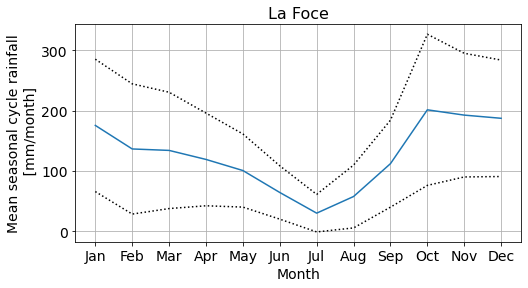

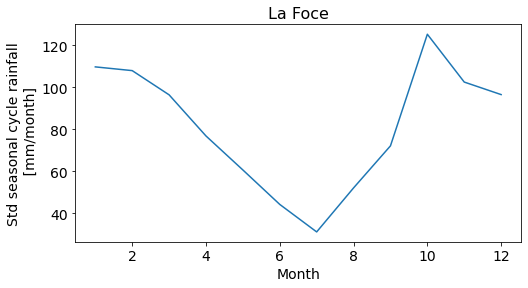

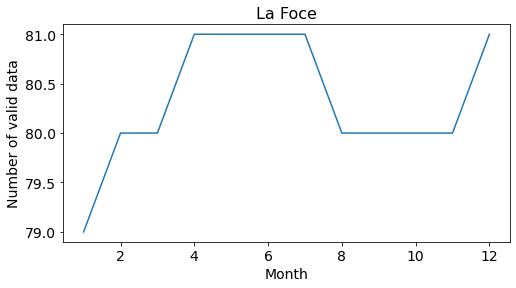

In [157]:
# Calculate the seasonal cycle. It is assumed that the first month of the record is Jan.

rainfall_year_rows = np.zeros((len(year_from_beg),12))

for k in range(len(year_from_beg)):
    rainfall_year_rows[k,:] = rainfall_with_nan[12*k:12*(k+1)]
    
seasonal_cycle_mean = np.nanmean(rainfall_year_rows,axis=0)
seasonal_cycle_std = np.nanstd(rainfall_year_rows,axis=0)
seasonal_cycle_num = np.sum(np.double(~np.isnan(rainfall_year_rows)),axis=0)

plt.figure(figsize=(8,4))
plt.plot(np.arange(12), seasonal_cycle_mean)
plt.plot(np.arange(12), seasonal_cycle_mean-seasonal_cycle_std,':k')
plt.plot(np.arange(12), seasonal_cycle_mean+seasonal_cycle_std,':k')
plt.ylabel('Mean seasonal cycle rainfall\n [mm/month]',fontsize=14)
plt.xlabel('Month',fontsize=14)
plt.title(title_str,fontsize=16)
plt.xticks(ticks=np.arange(12),labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.tick_params(axis='both', labelsize=14)
plt.grid()
plt.savefig(case_study + '_seasonal_cycle.png',bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(np.arange(1,13), seasonal_cycle_std)
plt.ylabel('Std seasonal cycle rainfall\n [mm/month]',fontsize=14)
plt.xlabel('Month',fontsize=14)
plt.title(title_str,fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(np.arange(1,13), seasonal_cycle_num)
plt.ylabel('Number of valid data',fontsize=14)
plt.xlabel('Month',fontsize=14)
plt.title(title_str,fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.show()

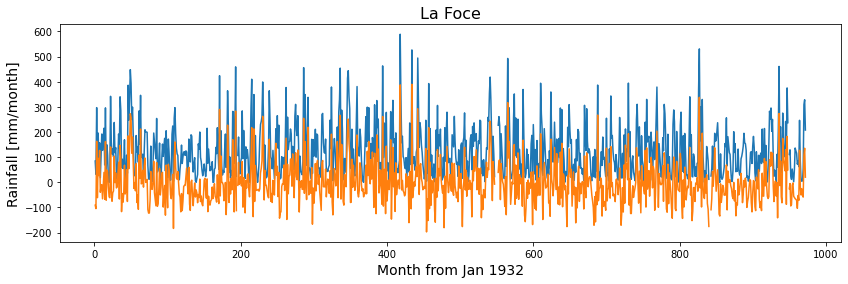

In [158]:
# Remove the seasonal cycle and do the Fourier analysis. The first month of the record is supposed to be Jan.

rainfall_no_ss = np.zeros(len(rainfall_with_nan))
for ll in range(len(rainfall_with_nan)):
    moy = ll%12 # month of the year
    rainfall_no_ss[ll] = rainfall_with_nan[ll] - seasonal_cycle_mean[moy]

plt.figure(figsize=(14,4))

plt.plot(month_from_beg, df.rainfall)
plt.ylabel('Rainfall [mm/month]',fontsize=14)
plt.xlabel('Month from ' + str(df.month[0]) +' '+ str(df.year[0]),fontsize=14)
plt.title(title_str,fontsize=16)

plt.plot(month_from_beg,rainfall_no_ss)

<ipython-input-159-e6fa90801816>:5: RuntimeWarning: Mean of empty slice
  son_rainfall[yl]=np.nanmean(rainfall_with_nan[8+yl*12:11+yl*12])
<ipython-input-159-e6fa90801816>:6: RuntimeWarning: Mean of empty slice
  son_rainfall_no_ss[yl]=np.nanmean(rainfall_no_ss[8+yl*12:11+yl*12])


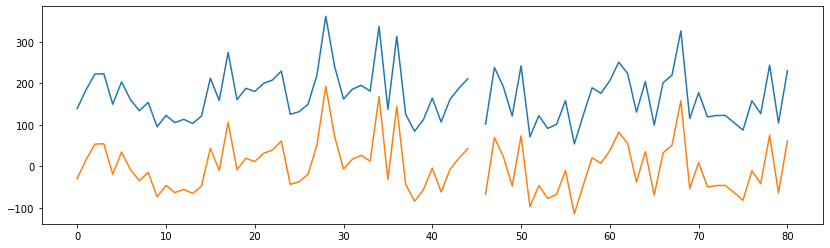

In [159]:
# Take the SON rainfall (with and without the seasonal cycle).
son_rainfall = np.zeros(len(year_from_beg))
son_rainfall_no_ss = np.zeros(len(year_from_beg))
for yl in range(len(year_from_beg)):
    son_rainfall[yl]=np.nanmean(rainfall_with_nan[8+yl*12:11+yl*12])
    son_rainfall_no_ss[yl]=np.nanmean(rainfall_no_ss[8+yl*12:11+yl*12])    

plt.figure(figsize=(14,4))
plt.plot(son_rainfall)
plt.plot(son_rainfall_no_ss)